# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels_20percent.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels_20percent.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(25192, 120)

In [4]:
dataset.kdd_test_2labels.shape

(11850, 120)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values
    y_test = y_test.values

preprocess.x_train.shape

(25192, 118)

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 118
    classes = 2
    hidden_encoder_dim = 118
    hidden_layers = 1
    latent_dim = 18

    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
            #hidden_encoder = tf.layers.dense(self.x, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            #hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(hidden_encoder, classes, activation=tf.nn.softmax)
            
        with tf.variable_scope("Loss"):
            
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            #loss = tf.clip_by_value(loss, -1e-1, 1e-1)
            #loss = tf.where(tf.is_nan(loss), 1e-1, loss)
            #loss = tf.where(tf.equal(loss, -1e-1), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-1), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = loss
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            #gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            #gradients = [
            #    None if gradient is None else tf.clip_by_value(gradient, -1, 1)
            #    for gradient in gradients]
            #self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score_20', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_dense_only_nsl_kdd_/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                               net.regularized_loss, 
                                                               ], #net.summary_op
                                                              feed_dict={net.x: x_train[i,:], 
                                                                         net.y_: y_train[i,:], 
                                                                         net.keep_prob:0.5, net.lr:lr})

                        train_batch()
                        #summary_writer_train.add_summary(summary_str, epoch)
                        while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1):
                            print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_dense_only_nsl_kdd/hidden_layers_{}_features_count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()


                    valid_accuracy = sess.run(net.tf_accuracy, #net.summary_op 
                                                          feed_dict={net.x: x_valid, 
                                                                     net.y_: y_valid, 
                                                                     net.keep_prob:1, net.lr:lr})
                    #summary_writer_valid.add_summary(summary_str, epoch)


                    accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})

                    print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f} | Test Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy, accuracy))
                   
                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:
                        Train.best_acc = accuracy

                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_dense_only_nsl_kdd_/hidden_layers_{}_features_count_{}".format(h,f),
                                        global_step = epochs)
                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format(epochs*len(lrs),f,h):(curr_pred, 
                                                   Train.result(epochs*len(lrs), f, h,valid_accuracy, accuracy, time.perf_counter() - start_time))})

                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))


In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 16, 32]
    hidden_layers_arr = [2, 4, 6]
    
    epochs = [70]
    lrs = [1e-6, 1e-6/2, 1e-6/4]
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f, lrs)
        

Current Layer Attributes - epochs:70 hidden layers:2 features count:4
Step 1 | Training Loss: 0.644382 | Validation Accuracy: 0.832540 | Test Accuracy: 0.796203
Step 2 | Training Loss: 0.661718 | Validation Accuracy: 0.819444 | Test Accuracy: 0.794262
Step 3 | Training Loss: 0.650340 | Validation Accuracy: 0.820238 | Test Accuracy: 0.793924
Step 4 | Training Loss: 0.694878 | Validation Accuracy: 0.814683 | Test Accuracy: 0.793333
Step 5 | Training Loss: 0.649780 | Validation Accuracy: 0.824603 | Test Accuracy: 0.793671
Step 6 | Training Loss: 0.662603 | Validation Accuracy: 0.837302 | Test Accuracy: 0.792321
Step 7 | Training Loss: 0.620044 | Validation Accuracy: 0.838889 | Test Accuracy: 0.790717
Step 8 | Training Loss: 0.663139 | Validation Accuracy: 0.857937 | Test Accuracy: 0.789536
Step 9 | Training Loss: 0.653894 | Validation Accuracy: 0.848810 | Test Accuracy: 0.789873
Step 10 | Training Loss: 0.628349 | Validation Accuracy: 0.865873 | Test Accuracy: 0.790380
Step 11 | Training 

Step 20 | Training Loss: 0.582988 | Validation Accuracy: 0.926587 | Test Accuracy: 0.733333
Step 21 | Training Loss: 0.592399 | Validation Accuracy: 0.921429 | Test Accuracy: 0.733165
Step 22 | Training Loss: 0.590031 | Validation Accuracy: 0.913492 | Test Accuracy: 0.733249
Step 23 | Training Loss: 0.575704 | Validation Accuracy: 0.918254 | Test Accuracy: 0.733165
Step 24 | Training Loss: 0.588329 | Validation Accuracy: 0.926190 | Test Accuracy: 0.732996
Step 25 | Training Loss: 0.583574 | Validation Accuracy: 0.918254 | Test Accuracy: 0.732996
Step 26 | Training Loss: 0.565451 | Validation Accuracy: 0.910714 | Test Accuracy: 0.732911
Step 27 | Training Loss: 0.565966 | Validation Accuracy: 0.912698 | Test Accuracy: 0.732911
Step 28 | Training Loss: 0.563290 | Validation Accuracy: 0.924603 | Test Accuracy: 0.732827
Step 29 | Training Loss: 0.564462 | Validation Accuracy: 0.916270 | Test Accuracy: 0.732911
Step 30 | Training Loss: 0.599581 | Validation Accuracy: 0.917460 | Test Accurac

Step 40 | Training Loss: 0.518727 | Validation Accuracy: 0.926587 | Test Accuracy: 0.731224
Step 41 | Training Loss: 0.575158 | Validation Accuracy: 0.919841 | Test Accuracy: 0.731224
Step 42 | Training Loss: 0.555204 | Validation Accuracy: 0.929762 | Test Accuracy: 0.731139
Step 43 | Training Loss: 0.538739 | Validation Accuracy: 0.927381 | Test Accuracy: 0.731139
Step 44 | Training Loss: 0.559858 | Validation Accuracy: 0.932540 | Test Accuracy: 0.731055
Step 45 | Training Loss: 0.536731 | Validation Accuracy: 0.930159 | Test Accuracy: 0.730886
Step 46 | Training Loss: 0.550906 | Validation Accuracy: 0.936905 | Test Accuracy: 0.730886
Step 47 | Training Loss: 0.559350 | Validation Accuracy: 0.923016 | Test Accuracy: 0.730886
Step 48 | Training Loss: 0.563732 | Validation Accuracy: 0.923016 | Test Accuracy: 0.730886
Step 49 | Training Loss: 0.539603 | Validation Accuracy: 0.925397 | Test Accuracy: 0.730886
Step 50 | Training Loss: 0.558818 | Validation Accuracy: 0.930556 | Test Accurac

Step 59 | Training Loss: 0.631268 | Validation Accuracy: 0.867460 | Test Accuracy: 0.652152
Step 60 | Training Loss: 0.632125 | Validation Accuracy: 0.860317 | Test Accuracy: 0.654768
Step 61 | Training Loss: 0.598658 | Validation Accuracy: 0.865476 | Test Accuracy: 0.658228
Step 62 | Training Loss: 0.619335 | Validation Accuracy: 0.871032 | Test Accuracy: 0.662532
Step 63 | Training Loss: 0.597312 | Validation Accuracy: 0.874206 | Test Accuracy: 0.665063
Step 64 | Training Loss: 0.603430 | Validation Accuracy: 0.873810 | Test Accuracy: 0.669198
Step 65 | Training Loss: 0.573658 | Validation Accuracy: 0.875794 | Test Accuracy: 0.672236
Step 66 | Training Loss: 0.588673 | Validation Accuracy: 0.880159 | Test Accuracy: 0.674430
Step 67 | Training Loss: 0.606105 | Validation Accuracy: 0.886905 | Test Accuracy: 0.676793
Step 68 | Training Loss: 0.602839 | Validation Accuracy: 0.885317 | Test Accuracy: 0.678228
Step 69 | Training Loss: 0.600499 | Validation Accuracy: 0.878968 | Test Accurac

Step 9 | Training Loss: 0.563968 | Validation Accuracy: 0.922619 | Test Accuracy: 0.721688
Step 10 | Training Loss: 0.564983 | Validation Accuracy: 0.923810 | Test Accuracy: 0.721857
Step 11 | Training Loss: 0.575192 | Validation Accuracy: 0.919048 | Test Accuracy: 0.721941
Step 12 | Training Loss: 0.545393 | Validation Accuracy: 0.924603 | Test Accuracy: 0.721941
Step 13 | Training Loss: 0.541692 | Validation Accuracy: 0.926587 | Test Accuracy: 0.722025
Step 14 | Training Loss: 0.542640 | Validation Accuracy: 0.922222 | Test Accuracy: 0.722110
Step 15 | Training Loss: 0.527672 | Validation Accuracy: 0.934127 | Test Accuracy: 0.722447
Step 16 | Training Loss: 0.604162 | Validation Accuracy: 0.917063 | Test Accuracy: 0.722616
Step 17 | Training Loss: 0.528228 | Validation Accuracy: 0.925397 | Test Accuracy: 0.722616
Step 18 | Training Loss: 0.542741 | Validation Accuracy: 0.929762 | Test Accuracy: 0.722700
Step 19 | Training Loss: 0.553586 | Validation Accuracy: 0.927778 | Test Accuracy

Step 28 | Training Loss: 0.669078 | Validation Accuracy: 0.452778 | Test Accuracy: 0.818565
Step 29 | Training Loss: 0.631626 | Validation Accuracy: 0.466270 | Test Accuracy: 0.818565
Step 30 | Training Loss: 0.648188 | Validation Accuracy: 0.467460 | Test Accuracy: 0.818565
Step 31 | Training Loss: 0.652151 | Validation Accuracy: 0.468254 | Test Accuracy: 0.818565
Step 32 | Training Loss: 0.638471 | Validation Accuracy: 0.463492 | Test Accuracy: 0.818565
Step 33 | Training Loss: 0.634014 | Validation Accuracy: 0.464286 | Test Accuracy: 0.818565
Step 34 | Training Loss: 0.622609 | Validation Accuracy: 0.453175 | Test Accuracy: 0.818565
Step 35 | Training Loss: 0.624608 | Validation Accuracy: 0.449603 | Test Accuracy: 0.818650
Step 36 | Training Loss: 0.645128 | Validation Accuracy: 0.472222 | Test Accuracy: 0.818650
Step 37 | Training Loss: 0.638979 | Validation Accuracy: 0.463889 | Test Accuracy: 0.818650
Step 38 | Training Loss: 0.648664 | Validation Accuracy: 0.476984 | Test Accurac

Step 48 | Training Loss: 0.597407 | Validation Accuracy: 0.886111 | Test Accuracy: 0.812658
Step 49 | Training Loss: 0.581532 | Validation Accuracy: 0.889286 | Test Accuracy: 0.812996
Step 50 | Training Loss: 0.571224 | Validation Accuracy: 0.886905 | Test Accuracy: 0.812743
Step 51 | Training Loss: 0.544802 | Validation Accuracy: 0.893254 | Test Accuracy: 0.811814
Step 52 | Training Loss: 0.591295 | Validation Accuracy: 0.880952 | Test Accuracy: 0.811646
Step 53 | Training Loss: 0.558423 | Validation Accuracy: 0.889683 | Test Accuracy: 0.811224
Step 54 | Training Loss: 0.628314 | Validation Accuracy: 0.894444 | Test Accuracy: 0.810633
Step 55 | Training Loss: 0.578507 | Validation Accuracy: 0.898413 | Test Accuracy: 0.809705
Step 56 | Training Loss: 0.617775 | Validation Accuracy: 0.886508 | Test Accuracy: 0.809367
Step 57 | Training Loss: 0.606275 | Validation Accuracy: 0.894841 | Test Accuracy: 0.808861
Step 58 | Training Loss: 0.576318 | Validation Accuracy: 0.892460 | Test Accurac

Step 68 | Training Loss: 0.580916 | Validation Accuracy: 0.913889 | Test Accuracy: 0.786498
Step 69 | Training Loss: 0.556092 | Validation Accuracy: 0.911508 | Test Accuracy: 0.786076
Step 70 | Training Loss: 0.559905 | Validation Accuracy: 0.917857 | Test Accuracy: 0.785738
Current Layer Attributes - epochs:70 hidden layers:2 features count:32
Step 1 | Training Loss: 0.666455 | Validation Accuracy: 0.676984 | Test Accuracy: 0.798228
Step 2 | Training Loss: 0.700680 | Validation Accuracy: 0.669048 | Test Accuracy: 0.802447
Step 3 | Training Loss: 0.719965 | Validation Accuracy: 0.692064 | Test Accuracy: 0.805823
Step 4 | Training Loss: 0.625293 | Validation Accuracy: 0.729365 | Test Accuracy: 0.809705
Step 5 | Training Loss: 0.702460 | Validation Accuracy: 0.721825 | Test Accuracy: 0.813586
Step 6 | Training Loss: 0.651955 | Validation Accuracy: 0.706349 | Test Accuracy: 0.815190
Step 7 | Training Loss: 0.641191 | Validation Accuracy: 0.725397 | Test Accuracy: 0.817806
Step 8 | Trainin

Step 17 | Training Loss: 0.499443 | Validation Accuracy: 0.877778 | Test Accuracy: 0.806835
Step 18 | Training Loss: 0.535556 | Validation Accuracy: 0.901190 | Test Accuracy: 0.806920
Step 19 | Training Loss: 0.491303 | Validation Accuracy: 0.889286 | Test Accuracy: 0.806920
Step 20 | Training Loss: 0.517810 | Validation Accuracy: 0.880952 | Test Accuracy: 0.806751
Step 21 | Training Loss: 0.490135 | Validation Accuracy: 0.885317 | Test Accuracy: 0.806835
Step 22 | Training Loss: 0.490521 | Validation Accuracy: 0.893254 | Test Accuracy: 0.806667
Step 23 | Training Loss: 0.484951 | Validation Accuracy: 0.888492 | Test Accuracy: 0.806582
Step 24 | Training Loss: 0.492203 | Validation Accuracy: 0.877778 | Test Accuracy: 0.806582
Step 25 | Training Loss: 0.495475 | Validation Accuracy: 0.886905 | Test Accuracy: 0.806751
Step 26 | Training Loss: 0.488644 | Validation Accuracy: 0.889286 | Test Accuracy: 0.806582
Step 27 | Training Loss: 0.487955 | Validation Accuracy: 0.899603 | Test Accurac

Step 37 | Training Loss: 0.476355 | Validation Accuracy: 0.937698 | Test Accuracy: 0.805738
Step 38 | Training Loss: 0.463270 | Validation Accuracy: 0.926190 | Test Accuracy: 0.805823
Step 39 | Training Loss: 0.462471 | Validation Accuracy: 0.927381 | Test Accuracy: 0.805738
Step 40 | Training Loss: 0.478088 | Validation Accuracy: 0.936508 | Test Accuracy: 0.805654
Step 41 | Training Loss: 0.452906 | Validation Accuracy: 0.931349 | Test Accuracy: 0.805654
Step 42 | Training Loss: 0.443473 | Validation Accuracy: 0.944048 | Test Accuracy: 0.805485
Step 43 | Training Loss: 0.461737 | Validation Accuracy: 0.934921 | Test Accuracy: 0.805401
Step 44 | Training Loss: 0.477341 | Validation Accuracy: 0.934921 | Test Accuracy: 0.805401
Step 45 | Training Loss: 0.426044 | Validation Accuracy: 0.947222 | Test Accuracy: 0.805232
Step 46 | Training Loss: 0.499641 | Validation Accuracy: 0.937302 | Test Accuracy: 0.805148
Step 47 | Training Loss: 0.410124 | Validation Accuracy: 0.935317 | Test Accurac

Step 56 | Training Loss: 0.678834 | Validation Accuracy: 0.537698 | Test Accuracy: 0.181603
Step 57 | Training Loss: 0.660248 | Validation Accuracy: 0.526984 | Test Accuracy: 0.181603
Step 58 | Training Loss: 0.699141 | Validation Accuracy: 0.526984 | Test Accuracy: 0.181603
Step 59 | Training Loss: 0.663786 | Validation Accuracy: 0.523810 | Test Accuracy: 0.181603
Step 60 | Training Loss: 0.682635 | Validation Accuracy: 0.538095 | Test Accuracy: 0.181603
Step 61 | Training Loss: 0.720756 | Validation Accuracy: 0.521825 | Test Accuracy: 0.181603
Step 62 | Training Loss: 0.679287 | Validation Accuracy: 0.521032 | Test Accuracy: 0.181603
Step 63 | Training Loss: 0.669807 | Validation Accuracy: 0.539683 | Test Accuracy: 0.181603
Step 64 | Training Loss: 0.680968 | Validation Accuracy: 0.545635 | Test Accuracy: 0.181603
Step 65 | Training Loss: 0.693438 | Validation Accuracy: 0.541270 | Test Accuracy: 0.181603
Step 66 | Training Loss: 0.677064 | Validation Accuracy: 0.531746 | Test Accurac

Step 6 | Training Loss: 0.717310 | Validation Accuracy: 0.758730 | Test Accuracy: 0.329620
Step 7 | Training Loss: 0.666585 | Validation Accuracy: 0.748016 | Test Accuracy: 0.329789
Step 8 | Training Loss: 0.670995 | Validation Accuracy: 0.761111 | Test Accuracy: 0.330042
Step 9 | Training Loss: 0.669562 | Validation Accuracy: 0.753175 | Test Accuracy: 0.330380
Step 10 | Training Loss: 0.665467 | Validation Accuracy: 0.740873 | Test Accuracy: 0.330464
Step 11 | Training Loss: 0.649169 | Validation Accuracy: 0.749603 | Test Accuracy: 0.330970
Step 12 | Training Loss: 0.705301 | Validation Accuracy: 0.754365 | Test Accuracy: 0.331055
Step 13 | Training Loss: 0.700740 | Validation Accuracy: 0.741667 | Test Accuracy: 0.331139
Step 14 | Training Loss: 0.653152 | Validation Accuracy: 0.750397 | Test Accuracy: 0.331308
Step 15 | Training Loss: 0.691325 | Validation Accuracy: 0.745635 | Test Accuracy: 0.331224
Step 16 | Training Loss: 0.666122 | Validation Accuracy: 0.740476 | Test Accuracy: 0

Step 25 | Training Loss: 0.701243 | Validation Accuracy: 0.683333 | Test Accuracy: 0.633587
Step 26 | Training Loss: 0.676264 | Validation Accuracy: 0.686111 | Test Accuracy: 0.631646
Step 27 | Training Loss: 0.695372 | Validation Accuracy: 0.691667 | Test Accuracy: 0.629283
Step 28 | Training Loss: 0.693510 | Validation Accuracy: 0.701190 | Test Accuracy: 0.625823
Step 29 | Training Loss: 0.729386 | Validation Accuracy: 0.713095 | Test Accuracy: 0.622447
Step 30 | Training Loss: 0.686356 | Validation Accuracy: 0.716667 | Test Accuracy: 0.618734
Step 31 | Training Loss: 0.699861 | Validation Accuracy: 0.703968 | Test Accuracy: 0.615696
Step 32 | Training Loss: 0.721175 | Validation Accuracy: 0.705556 | Test Accuracy: 0.612658
Step 33 | Training Loss: 0.681123 | Validation Accuracy: 0.713095 | Test Accuracy: 0.609030
Step 34 | Training Loss: 0.726448 | Validation Accuracy: 0.742063 | Test Accuracy: 0.606582
Step 35 | Training Loss: 0.622729 | Validation Accuracy: 0.719841 | Test Accurac

Step 45 | Training Loss: 0.698575 | Validation Accuracy: 0.822222 | Test Accuracy: 0.591814
Step 46 | Training Loss: 0.703866 | Validation Accuracy: 0.836905 | Test Accuracy: 0.591730
Step 47 | Training Loss: 0.683461 | Validation Accuracy: 0.840873 | Test Accuracy: 0.591392
Step 48 | Training Loss: 0.682270 | Validation Accuracy: 0.842857 | Test Accuracy: 0.591561
Step 49 | Training Loss: 0.689553 | Validation Accuracy: 0.855556 | Test Accuracy: 0.591477
Step 50 | Training Loss: 0.675588 | Validation Accuracy: 0.834524 | Test Accuracy: 0.591224
Step 51 | Training Loss: 0.657361 | Validation Accuracy: 0.844841 | Test Accuracy: 0.591139
Step 52 | Training Loss: 0.703577 | Validation Accuracy: 0.832937 | Test Accuracy: 0.590970
Step 53 | Training Loss: 0.688727 | Validation Accuracy: 0.841667 | Test Accuracy: 0.591055
Step 54 | Training Loss: 0.696521 | Validation Accuracy: 0.844444 | Test Accuracy: 0.591308
Step 55 | Training Loss: 0.682320 | Validation Accuracy: 0.836905 | Test Accurac

Step 65 | Training Loss: 0.709294 | Validation Accuracy: 0.865873 | Test Accuracy: 0.596540
Step 66 | Training Loss: 0.702763 | Validation Accuracy: 0.865079 | Test Accuracy: 0.597215
Step 67 | Training Loss: 0.664384 | Validation Accuracy: 0.865079 | Test Accuracy: 0.597468
Step 68 | Training Loss: 0.702843 | Validation Accuracy: 0.875794 | Test Accuracy: 0.597468
Step 69 | Training Loss: 0.672970 | Validation Accuracy: 0.866667 | Test Accuracy: 0.597637
Step 70 | Training Loss: 0.663943 | Validation Accuracy: 0.875794 | Test Accuracy: 0.597637
Current Layer Attributes - epochs:70 hidden layers:4 features count:16
Step 1 | Training Loss: 0.729588 | Validation Accuracy: 0.519444 | Test Accuracy: 0.692321
Step 2 | Training Loss: 0.708430 | Validation Accuracy: 0.569841 | Test Accuracy: 0.690549
Step 3 | Training Loss: 0.711508 | Validation Accuracy: 0.628175 | Test Accuracy: 0.690380
Step 4 | Training Loss: 0.713672 | Validation Accuracy: 0.683333 | Test Accuracy: 0.690886
Step 5 | Trai

Step 14 | Training Loss: 0.653997 | Validation Accuracy: 0.854365 | Test Accuracy: 0.715527
Step 15 | Training Loss: 0.669586 | Validation Accuracy: 0.864286 | Test Accuracy: 0.715781
Step 16 | Training Loss: 0.652960 | Validation Accuracy: 0.865873 | Test Accuracy: 0.716034
Step 17 | Training Loss: 0.662761 | Validation Accuracy: 0.865873 | Test Accuracy: 0.715781
Step 18 | Training Loss: 0.672054 | Validation Accuracy: 0.863492 | Test Accuracy: 0.716034
Step 19 | Training Loss: 0.644982 | Validation Accuracy: 0.872222 | Test Accuracy: 0.716371
Step 20 | Training Loss: 0.676791 | Validation Accuracy: 0.866667 | Test Accuracy: 0.716540
Step 21 | Training Loss: 0.654608 | Validation Accuracy: 0.871032 | Test Accuracy: 0.716371
Step 22 | Training Loss: 0.657647 | Validation Accuracy: 0.857937 | Test Accuracy: 0.716034
Step 23 | Training Loss: 0.669910 | Validation Accuracy: 0.859921 | Test Accuracy: 0.716287
Step 24 | Training Loss: 0.630587 | Validation Accuracy: 0.868254 | Test Accurac

Step 34 | Training Loss: 0.679508 | Validation Accuracy: 0.875000 | Test Accuracy: 0.683797
Step 35 | Training Loss: 0.658692 | Validation Accuracy: 0.875794 | Test Accuracy: 0.683207
Step 36 | Training Loss: 0.659339 | Validation Accuracy: 0.875000 | Test Accuracy: 0.682869
Step 37 | Training Loss: 0.651242 | Validation Accuracy: 0.875397 | Test Accuracy: 0.682785
Step 38 | Training Loss: 0.636090 | Validation Accuracy: 0.895238 | Test Accuracy: 0.682532
Step 39 | Training Loss: 0.667700 | Validation Accuracy: 0.891667 | Test Accuracy: 0.682194
Step 40 | Training Loss: 0.673083 | Validation Accuracy: 0.872222 | Test Accuracy: 0.681857
Step 41 | Training Loss: 0.637337 | Validation Accuracy: 0.880952 | Test Accuracy: 0.681941
Step 42 | Training Loss: 0.660442 | Validation Accuracy: 0.884921 | Test Accuracy: 0.681603
Step 43 | Training Loss: 0.611621 | Validation Accuracy: 0.878571 | Test Accuracy: 0.681266
Step 44 | Training Loss: 0.639305 | Validation Accuracy: 0.878571 | Test Accurac

Step 53 | Training Loss: 0.818723 | Validation Accuracy: 0.521825 | Test Accuracy: 0.181603
Step 54 | Training Loss: 0.766640 | Validation Accuracy: 0.537302 | Test Accuracy: 0.181603
Step 55 | Training Loss: 0.727957 | Validation Accuracy: 0.547222 | Test Accuracy: 0.181603
Step 56 | Training Loss: 0.732539 | Validation Accuracy: 0.545238 | Test Accuracy: 0.181603
Step 57 | Training Loss: 0.735227 | Validation Accuracy: 0.538889 | Test Accuracy: 0.181603
Step 58 | Training Loss: 0.760922 | Validation Accuracy: 0.534127 | Test Accuracy: 0.181603
Step 59 | Training Loss: 0.679300 | Validation Accuracy: 0.523016 | Test Accuracy: 0.181603
Step 60 | Training Loss: 0.762033 | Validation Accuracy: 0.534524 | Test Accuracy: 0.181603
Step 61 | Training Loss: 0.678072 | Validation Accuracy: 0.525794 | Test Accuracy: 0.181603
Step 62 | Training Loss: 0.721737 | Validation Accuracy: 0.533730 | Test Accuracy: 0.181603
Step 63 | Training Loss: 0.708768 | Validation Accuracy: 0.517460 | Test Accurac

Step 3 | Training Loss: 0.687482 | Validation Accuracy: 0.653968 | Test Accuracy: 0.189958
Step 4 | Training Loss: 0.738114 | Validation Accuracy: 0.641667 | Test Accuracy: 0.190295
Step 5 | Training Loss: 0.703144 | Validation Accuracy: 0.656746 | Test Accuracy: 0.190464
Step 6 | Training Loss: 0.715129 | Validation Accuracy: 0.653571 | Test Accuracy: 0.190549
Step 7 | Training Loss: 0.692892 | Validation Accuracy: 0.657540 | Test Accuracy: 0.190886
Step 8 | Training Loss: 0.688667 | Validation Accuracy: 0.651587 | Test Accuracy: 0.191224
Step 9 | Training Loss: 0.684738 | Validation Accuracy: 0.663492 | Test Accuracy: 0.191561
Step 10 | Training Loss: 0.659066 | Validation Accuracy: 0.644048 | Test Accuracy: 0.191983
Step 11 | Training Loss: 0.674897 | Validation Accuracy: 0.653968 | Test Accuracy: 0.192321
Step 12 | Training Loss: 0.682421 | Validation Accuracy: 0.643651 | Test Accuracy: 0.192489
Step 13 | Training Loss: 0.692273 | Validation Accuracy: 0.640079 | Test Accuracy: 0.19

Step 22 | Training Loss: 0.693303 | Validation Accuracy: 0.526587 | Test Accuracy: 0.181603
Step 23 | Training Loss: 0.693058 | Validation Accuracy: 0.532143 | Test Accuracy: 0.181603
Step 24 | Training Loss: 0.698037 | Validation Accuracy: 0.530556 | Test Accuracy: 0.181603
Step 25 | Training Loss: 0.687653 | Validation Accuracy: 0.534921 | Test Accuracy: 0.181603
Step 26 | Training Loss: 0.700937 | Validation Accuracy: 0.537698 | Test Accuracy: 0.181603
Step 27 | Training Loss: 0.702426 | Validation Accuracy: 0.542460 | Test Accuracy: 0.181603
Step 28 | Training Loss: 0.693915 | Validation Accuracy: 0.542857 | Test Accuracy: 0.181603
Step 29 | Training Loss: 0.693884 | Validation Accuracy: 0.535317 | Test Accuracy: 0.181603
Step 30 | Training Loss: 0.693543 | Validation Accuracy: 0.519841 | Test Accuracy: 0.181603
Step 31 | Training Loss: 0.689615 | Validation Accuracy: 0.532540 | Test Accuracy: 0.181603
Step 32 | Training Loss: 0.691302 | Validation Accuracy: 0.532143 | Test Accurac

Step 42 | Training Loss: 0.691189 | Validation Accuracy: 0.551190 | Test Accuracy: 0.181603
Step 43 | Training Loss: 0.687044 | Validation Accuracy: 0.521429 | Test Accuracy: 0.181603
Step 44 | Training Loss: 0.692761 | Validation Accuracy: 0.529762 | Test Accuracy: 0.181603
Step 45 | Training Loss: 0.687361 | Validation Accuracy: 0.534524 | Test Accuracy: 0.181603
Step 46 | Training Loss: 0.691135 | Validation Accuracy: 0.530159 | Test Accuracy: 0.181603
Step 47 | Training Loss: 0.693503 | Validation Accuracy: 0.535714 | Test Accuracy: 0.181603
Step 48 | Training Loss: 0.697617 | Validation Accuracy: 0.536111 | Test Accuracy: 0.181603
Step 49 | Training Loss: 0.684820 | Validation Accuracy: 0.545635 | Test Accuracy: 0.181603
Step 50 | Training Loss: 0.687700 | Validation Accuracy: 0.512302 | Test Accuracy: 0.181603
Step 51 | Training Loss: 0.679795 | Validation Accuracy: 0.515079 | Test Accuracy: 0.181603
Step 52 | Training Loss: 0.680672 | Validation Accuracy: 0.541270 | Test Accurac

Step 62 | Training Loss: 0.683442 | Validation Accuracy: 0.530556 | Test Accuracy: 0.181603
Step 63 | Training Loss: 0.684125 | Validation Accuracy: 0.526984 | Test Accuracy: 0.181603
Step 64 | Training Loss: 0.679429 | Validation Accuracy: 0.526190 | Test Accuracy: 0.181603
Step 65 | Training Loss: 0.687918 | Validation Accuracy: 0.525000 | Test Accuracy: 0.181603
Step 66 | Training Loss: 0.685265 | Validation Accuracy: 0.545238 | Test Accuracy: 0.181603
Step 67 | Training Loss: 0.685309 | Validation Accuracy: 0.527381 | Test Accuracy: 0.181603
Step 68 | Training Loss: 0.688144 | Validation Accuracy: 0.533333 | Test Accuracy: 0.181603
Step 69 | Training Loss: 0.693633 | Validation Accuracy: 0.532540 | Test Accuracy: 0.181603
Step 70 | Training Loss: 0.683719 | Validation Accuracy: 0.551984 | Test Accuracy: 0.181603
Current Layer Attributes - epochs:70 hidden layers:6 features count:8
Step 1 | Training Loss: 0.718227 | Validation Accuracy: 0.394841 | Test Accuracy: 0.817468
Step 2 | Tr

Step 11 | Training Loss: 0.679915 | Validation Accuracy: 0.754365 | Test Accuracy: 0.712067
Step 12 | Training Loss: 0.694430 | Validation Accuracy: 0.734127 | Test Accuracy: 0.710886
Step 13 | Training Loss: 0.707469 | Validation Accuracy: 0.749603 | Test Accuracy: 0.708861
Step 14 | Training Loss: 0.717903 | Validation Accuracy: 0.756746 | Test Accuracy: 0.706835
Step 15 | Training Loss: 0.683271 | Validation Accuracy: 0.740873 | Test Accuracy: 0.704726
Step 16 | Training Loss: 0.684558 | Validation Accuracy: 0.725000 | Test Accuracy: 0.704641
Step 17 | Training Loss: 0.687245 | Validation Accuracy: 0.736111 | Test Accuracy: 0.707848
Step 18 | Training Loss: 0.719261 | Validation Accuracy: 0.746825 | Test Accuracy: 0.713840
Step 19 | Training Loss: 0.706017 | Validation Accuracy: 0.738492 | Test Accuracy: 0.720844
Step 20 | Training Loss: 0.655141 | Validation Accuracy: 0.743651 | Test Accuracy: 0.720844
Step 21 | Training Loss: 0.697375 | Validation Accuracy: 0.728968 | Test Accurac

Step 31 | Training Loss: 0.688986 | Validation Accuracy: 0.799603 | Test Accuracy: 0.640928
Step 32 | Training Loss: 0.709881 | Validation Accuracy: 0.808333 | Test Accuracy: 0.640422
Step 33 | Training Loss: 0.695177 | Validation Accuracy: 0.809127 | Test Accuracy: 0.639747
Step 34 | Training Loss: 0.706647 | Validation Accuracy: 0.794048 | Test Accuracy: 0.639072
Step 35 | Training Loss: 0.679390 | Validation Accuracy: 0.803175 | Test Accuracy: 0.638397
Step 36 | Training Loss: 0.716671 | Validation Accuracy: 0.789683 | Test Accuracy: 0.637806
Step 37 | Training Loss: 0.657245 | Validation Accuracy: 0.793651 | Test Accuracy: 0.637131
Step 38 | Training Loss: 0.673319 | Validation Accuracy: 0.788492 | Test Accuracy: 0.636456
Step 39 | Training Loss: 0.677952 | Validation Accuracy: 0.792857 | Test Accuracy: 0.635612
Step 40 | Training Loss: 0.657658 | Validation Accuracy: 0.788889 | Test Accuracy: 0.634430
Step 41 | Training Loss: 0.704461 | Validation Accuracy: 0.793651 | Test Accurac

Step 50 | Training Loss: 0.723566 | Validation Accuracy: 0.528175 | Test Accuracy: 0.213165
Step 51 | Training Loss: 0.691147 | Validation Accuracy: 0.527381 | Test Accuracy: 0.213165
Step 52 | Training Loss: 0.748309 | Validation Accuracy: 0.544048 | Test Accuracy: 0.213165
Step 53 | Training Loss: 0.693458 | Validation Accuracy: 0.548016 | Test Accuracy: 0.213165
Step 54 | Training Loss: 0.683298 | Validation Accuracy: 0.548016 | Test Accuracy: 0.213165
Step 55 | Training Loss: 0.723642 | Validation Accuracy: 0.550794 | Test Accuracy: 0.213165
Step 56 | Training Loss: 0.744713 | Validation Accuracy: 0.534127 | Test Accuracy: 0.213165
Step 57 | Training Loss: 0.726752 | Validation Accuracy: 0.527778 | Test Accuracy: 0.213165
Step 58 | Training Loss: 0.738597 | Validation Accuracy: 0.545635 | Test Accuracy: 0.213165
Step 59 | Training Loss: 0.728268 | Validation Accuracy: 0.527381 | Test Accuracy: 0.213165
Step 60 | Training Loss: 0.723843 | Validation Accuracy: 0.523413 | Test Accurac

Step 70 | Training Loss: 0.729948 | Validation Accuracy: 0.534921 | Test Accuracy: 0.212996
Step 1 | Training Loss: 0.714114 | Validation Accuracy: 0.532937 | Test Accuracy: 0.212996
Step 2 | Training Loss: 0.723245 | Validation Accuracy: 0.536905 | Test Accuracy: 0.212996
Step 3 | Training Loss: 0.704268 | Validation Accuracy: 0.534524 | Test Accuracy: 0.212996
Step 4 | Training Loss: 0.688888 | Validation Accuracy: 0.537302 | Test Accuracy: 0.212996
Step 5 | Training Loss: 0.716289 | Validation Accuracy: 0.526190 | Test Accuracy: 0.212996
Step 6 | Training Loss: 0.698718 | Validation Accuracy: 0.526190 | Test Accuracy: 0.212996
Step 7 | Training Loss: 0.688593 | Validation Accuracy: 0.560317 | Test Accuracy: 0.212996
Step 8 | Training Loss: 0.675714 | Validation Accuracy: 0.519841 | Test Accuracy: 0.212911
Step 9 | Training Loss: 0.706044 | Validation Accuracy: 0.551587 | Test Accuracy: 0.212911
Step 10 | Training Loss: 0.742266 | Validation Accuracy: 0.524603 | Test Accuracy: 0.2129

Step 19 | Training Loss: 0.693101 | Validation Accuracy: 0.575794 | Test Accuracy: 0.256878
Step 20 | Training Loss: 0.739739 | Validation Accuracy: 0.592857 | Test Accuracy: 0.258228
Step 21 | Training Loss: 0.723688 | Validation Accuracy: 0.588889 | Test Accuracy: 0.259747
Step 22 | Training Loss: 0.714764 | Validation Accuracy: 0.582143 | Test Accuracy: 0.262785
Step 23 | Training Loss: 0.705740 | Validation Accuracy: 0.571032 | Test Accuracy: 0.264641
Step 24 | Training Loss: 0.715284 | Validation Accuracy: 0.557143 | Test Accuracy: 0.265992
Step 25 | Training Loss: 0.678404 | Validation Accuracy: 0.587302 | Test Accuracy: 0.269198
Step 26 | Training Loss: 0.710170 | Validation Accuracy: 0.584921 | Test Accuracy: 0.271308
Step 27 | Training Loss: 0.733486 | Validation Accuracy: 0.578571 | Test Accuracy: 0.271224
Step 28 | Training Loss: 0.700295 | Validation Accuracy: 0.573810 | Test Accuracy: 0.271308
Step 29 | Training Loss: 0.730552 | Validation Accuracy: 0.589683 | Test Accurac

Step 39 | Training Loss: 0.703588 | Validation Accuracy: 0.601587 | Test Accuracy: 0.283376
Step 40 | Training Loss: 0.662449 | Validation Accuracy: 0.607937 | Test Accuracy: 0.283460
Step 41 | Training Loss: 0.711377 | Validation Accuracy: 0.598413 | Test Accuracy: 0.283713
Step 42 | Training Loss: 0.690003 | Validation Accuracy: 0.598016 | Test Accuracy: 0.283882
Step 43 | Training Loss: 0.708137 | Validation Accuracy: 0.591270 | Test Accuracy: 0.284304
Step 44 | Training Loss: 0.686471 | Validation Accuracy: 0.617460 | Test Accuracy: 0.284895
Step 45 | Training Loss: 0.692660 | Validation Accuracy: 0.597619 | Test Accuracy: 0.285654
Step 46 | Training Loss: 0.689911 | Validation Accuracy: 0.605952 | Test Accuracy: 0.285738
Step 47 | Training Loss: 0.698723 | Validation Accuracy: 0.588095 | Test Accuracy: 0.285738
Step 48 | Training Loss: 0.696849 | Validation Accuracy: 0.595635 | Test Accuracy: 0.286076
Step 49 | Training Loss: 0.709328 | Validation Accuracy: 0.602778 | Test Accurac

Step 59 | Training Loss: 0.736931 | Validation Accuracy: 0.607540 | Test Accuracy: 0.305401
Step 60 | Training Loss: 0.682035 | Validation Accuracy: 0.609921 | Test Accuracy: 0.305654
Step 61 | Training Loss: 0.678743 | Validation Accuracy: 0.601587 | Test Accuracy: 0.305823
Step 62 | Training Loss: 0.682193 | Validation Accuracy: 0.605556 | Test Accuracy: 0.305992
Step 63 | Training Loss: 0.692529 | Validation Accuracy: 0.613095 | Test Accuracy: 0.306076
Step 64 | Training Loss: 0.702453 | Validation Accuracy: 0.613889 | Test Accuracy: 0.306245
Step 65 | Training Loss: 0.707487 | Validation Accuracy: 0.611905 | Test Accuracy: 0.306498
Step 66 | Training Loss: 0.676516 | Validation Accuracy: 0.620238 | Test Accuracy: 0.306582
Step 67 | Training Loss: 0.683464 | Validation Accuracy: 0.626984 | Test Accuracy: 0.306667
Step 68 | Training Loss: 0.710343 | Validation Accuracy: 0.609127 | Test Accuracy: 0.307004
Step 69 | Training Loss: 0.720380 | Validation Accuracy: 0.620238 | Test Accurac

In [10]:
dict1 = {}
dict2 = []
for k, (v1, v2) in Train.predictions.items():
    dict1.update({k: v1})
    dict2.append(v2)

In [11]:
Train.predictions = dict1
Train.results = dict2

In [12]:
df_results = pd.DataFrame(Train.results)

In [13]:
df_results.sort_values(by = 'test_score_20', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score_20,time_taken
2,210,16,2,0.631746,0.826076,24.369737
3,210,32,2,0.749206,0.825316,8.519440
9,210,8,6,0.394841,0.817468,1.101875
0,210,4,2,0.832540,0.796203,0.757201
1,210,8,2,0.919048,0.729536,138.027119
6,210,16,4,0.875397,0.718987,71.540299
5,210,8,4,0.593651,0.662363,8.212820
4,210,4,4,0.758333,0.340928,138.110573
11,210,32,6,0.608333,0.307342,213.206748
10,210,16,6,0.541270,0.213502,107.974580


In [14]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions-.pkl")
df_results.to_pickle("dataset/tf_dense_only_nsl_kdd_scores-.pkl")

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.9987  0.0013]
 [ 0.9517  0.0483]]


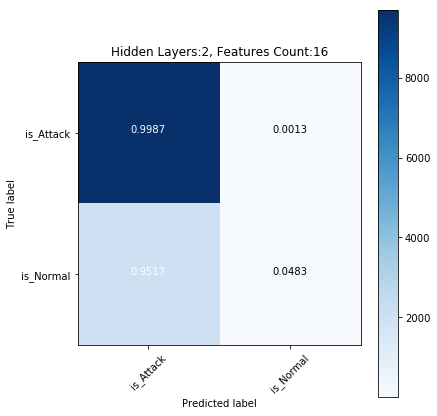

In [16]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)